In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Model Creation

1.1 Define the three-compartment model above using a system of ODEs

In [2]:
def equations(y, t, p):
    """
    Define system of ODEs describing the three compartment model
    :var: y = list of concentrations in all 3 compartents ([C1, C2, C3])
    :params: p = list of rate constants between comparments ([k10, k12, k13, k21, k31])
    :return: dydt = list of all differentials to be solved ([dc1dt, dc2dt, dc3dt])
    """
    # Define variables and parameters
    C1, C2, C3 = y
    k10, k12, k13, k21, k31 = p

    # Define ODEs
    dc1dt = -(k10 + k12 + k13)*C1 + k21*C2 + k31*C3
    dc2dt = k12*C1 - k21*C2
    dc3dt = k13*C1 - k31*C3

    dydt = np.asarray([dc1dt, dc2dt, dc3dt])
    return dydt

1.2 Solve the system of ODEs using a Forward Euler solver

In [3]:
def ForwardEuler(function, t0, tf, y0, n, p):
    """
    """
    h = (tf - t0)/n    # Time interval
    t = t0
    y = np.empty((n, 3))
    y[0] = y0
    for i in range(n-1):
        y[i+1] = y[i] + h*function(y[i], t, p)
        t += h
    return y

In [4]:
t0 = 0                   # Starting time
tf = 1                   # Final time
y0 = [10, 0, 0]          # Initial conditions for [C1, C2, C3]
n = 1000                 # Number of data points
p = [1, 6, 9, 6, 9]    # Parameter values for [k10, k12, k13, k21, k31]

In [5]:
model = ForwardEuler(equations, t0, tf, y0, n, p)

In [6]:
def calculate_model_data(function, t0, tf, y0, n, p):
    model = ForwardEuler(function, t0, tf, y0, n, p)
    I = np.asarray(model.i)
    I_model = I[:-1]
    return I_model

In [7]:
C1 = model[:,0]
C2 = model[:, 1]
C3 = model[:, 2]

times = np.linspace(0, 1, 1000)

1.3 Plot concentration-time profiles for each compartment

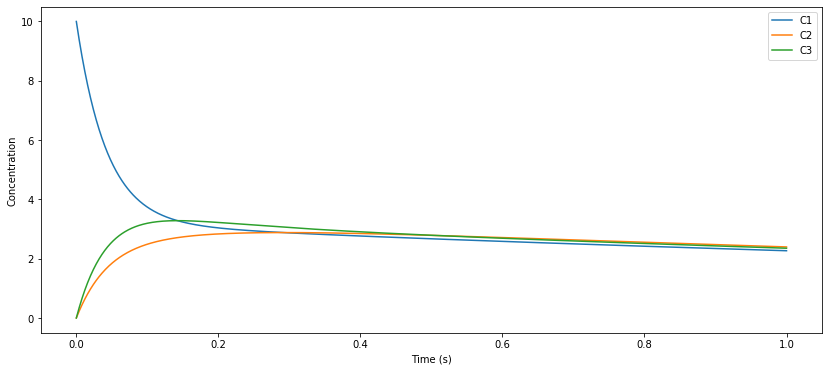

In [8]:
plt.figure(figsize=(14,6))
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.plot(times, C1, label='C1')
plt.plot(times, C2, label='C2')
plt.plot(times, C3, label='C3')
plt.legend(loc='best')
plt.show()

## 2. Data Generation
2.1 Add normally-distributed random noise to the model to simulate real-life noisy data

In [9]:
data = model + np.random.normal(size=model.shape)/3
C1 = data[:,0]
C2 = data[:, 1]
C3 = data[:, 2]

2.2 Plot concentration-time profile of data

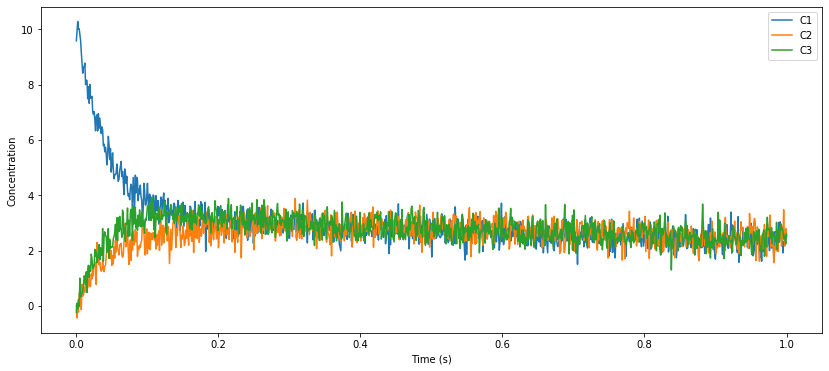

In [10]:
plt.figure(figsize=(14,6))
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.plot(times, C1, label='C1')
plt.plot(times, C2, label='C2')
plt.plot(times, C3, label='C3')
plt.legend(loc='best')
plt.show()

## 3. Parameter Inference

Probability of variables

In [11]:
# p += [0.247]      # add standard deviation
# print(p)
lower_bounds = [0, 4, 7, 4, 7, 0.1]
upper_bounds = [3, 7, 11, 7, 11, 0.8]
# prob = []
# for i in range(len(upper_bounds)):
#     if (p[i] <= upper_bounds[i] and p[i] >= lower_bounds[i]):
#         prob.append(1)
#     else:
#         prob.append(0)

# prob = np.asarray(prob)
# print(prob)
# prob = np.prod(prob)
# print(prob)

In [12]:
def probability_of_variables(p):
    prob = []
    for i in range(len(upper_bounds)):
        if (p[i] <= upper_bounds[i] and p[i] >= lower_bounds[i]):
            prob.append(1)
        else:
            prob.append(0)

        prob = np.asarray(prob)
        prob = np.prod(prob)
        return prob

Define objective function

In [13]:
# difference = data - model
# sum_of_squares = np.sum(np.square(difference))
# print(sum_of_squares)

In [14]:
def objective_function(function, t0, tf, y0, n, p):
    difference = data - model
    sum_of_squares = np.sum(np.square(difference))
    return sum_of_squares

Normal Distribution Sampler

In [15]:
def normal_dist_sampler(mean, standDev):
    temp = []
    maxIndex = mean.shape
    for i in range(maxIndex[0]):
        temp.append(np.random.normal(mean[i], standDev[i]))
    return temp

In [16]:
def likelihood(function, t0, tf, y0, n, p):
    
    k10, k12, k13, k21, k31, standDev = p
    A = 1/(np.sqrt(2*np.pi*(standDev**2)))
    
    power = -objective_function(function, t0, tf, y0, n, p)/(2*(standDev**2))
    tmp = tf*np.log(A)
    
    likely = tmp + power
    return likely

In [17]:
# def metropolisHastings():
#     a = [1]
#     print(p)
#     p0 = np.array([2, 5, 8, 5, 7])      #initial guess of parameters
#     means = np.asarray(p[0])
#     print(p)
#     print(means)
#     covariance = np.array([])
    

In [18]:
p0 = np.array([[2, 5, 8, 5, 7, 0.247]])
p += [0.247]

def metropolisHastings(p0):
    a = [1.0]    # initial guess of parameters
    means = np.asarray(p0[0])
    covariance = np.array([50, 50, 50, 50, 50, 0.02])
    t = 1
    
    indices = 100
    while t <= indices:
        p_temp = np.asarray([normal_dist_sampler(p0[-1], a[-1]*covariance)])
        
        if probability_of_variables(p_temp[0]) != 0:
            if np.log(np.random.uniform(0, 1)) < (likelihood(equations, t0, tf, y0, n, p_temp[0]) - likelihood(equations, t0, tf, y0, n, p0[-1])):
                p0 = np.append(p0, p_temp, axis=0)
                
        if t % 50 == 0:
            print('Iteration: ', t)
            print('Burn in k10: ', p0[-1][0])
            print('Burn in k12: ', p0[-1][1])
            print('Burn in k13: ', p0[-1][2])
            print('Burn in k21: ', p0[-1][3])
            print('Burn in k31: ', p0[-1][4])
            print('Burn in Standard Deviation: ', p0[-1][5])
            np.save('samples', p0)
        
        t += 1
    
    while t < indices*4:
        
        s = t - indices
        gammaS = (s+1)**(-0.6)
        p_temp = np.asarray([normal_dist_sampler(p0[-1], a[-1]*covariance)])
        
        if probability_of_variables(p_temp[0]) != 0:
            if np.log(np.random.uniform(0,1)) < likelihood(equations, t0, tf, y0, n, p_temp[0]) - likelihood(equations, t0, tf, y0, n, p0[-1]):
                p0 = np.append(p0, p_temp, axis=0)
                accepted = 1
            
            else:
                p0 = np.append(p0, [p0[-1]], axis=0)
                accepted = 0
            
        else:
            p0 = np.append(p0, [p0[-1]], axis=0)
            accepted = 0
            
        temp = p0[-1] - means
        covariance = ((1 - gammaS)*covariance + gammaS*np.square(temp))
        means = (1 - gammaS)*means + gammaS*p0[-1]
        a.append(np.exp(np.log(a[-1]) + gammaS*(accepted - 0.25)))
        
        if t % 50 == 0:
            print('total iteration: ', t)
            print('sampling iteration: ', s)
            print('fitted k10: ', p0[-1][0])
            print('fitted k12: ', p0[-1][1])
            print('fitted k13: ', p0[-1][2])
            print('fitted k21: ', p0[-1][3])
            print('fitted k31: ', p0[-1][4])
            print('fitted standard deviation: ', p0[-1][5])
            np.save('samples', p0)
        
        t += 1

In [19]:
comparison = objective_function(equations, t0, tf, y0, n, p)
print('Objective Function with original parameters: ', comparison)
print('Initial k10: ', p[0])
print('Initial k12: ', p[1])
print('Initial k13: ', p[2])
print('Initial k21: ', p[3])
print('Initial k31: ', p[4])
print('Initial Standard Deviation: ', p[5])
print('Likelihood with original parameters: ', likelihood(equations, t0, tf, y0, n, p))

Objective Function with original parameters:  335.674218643013
Initial k10:  1
Initial k12:  6
Initial k13:  9
Initial k21:  6
Initial k31:  9
Initial Standard Deviation:  0.247
Likelihood with original parameters:  -2750.5427047434428


In [20]:
print('Data: ', data)
print('Initial k10: ', p0[0][0])
print('Initial k12: ', p0[0][1])
print('Initial k13: ', p0[0][2])
print('Initial k21: ', p0[0][3])
print('Initial k31: ', p0[0][4])
print('Initial Standard Deviation: ', p0[0][5])
comparison = objective_function(equations, t0, tf, y0, n, p0[0])
print('Initial Objective Function: ', comparison)
print('Initial Likelihood: ', likelihood(equations, t0, tf, y0, n, p0[0]))

Data:  [[ 9.57858271  0.01370433 -0.24330131]
 [ 9.92224738 -0.43768535  0.09358181]
 [10.27837344  0.105585   -0.10439346]
 ...
 [ 2.61934372  2.17117213  2.36900446]
 [ 2.68715027  2.79234776  2.24110729]
 [ 2.53478443  2.47061937  2.60170628]]
Initial k10:  2.0
Initial k12:  5.0
Initial k13:  8.0
Initial k21:  5.0
Initial k31:  7.0
Initial Standard Deviation:  0.247
Initial Objective Function:  335.674218643013
Initial Likelihood:  -2750.5427047434428


In [21]:
metropolisHastings(p0)

Iteration:  50
Burn in k10:  0.49011291758749387
Burn in k12:  -83.16844367414484
Burn in k13:  -45.75276763288603
Burn in k21:  -89.55024587625286
Burn in k31:  -27.437199737415902
Burn in Standard Deviation:  0.27327942581335213
Iteration:  100
Burn in k10:  1.3385262776192768
Burn in k12:  0.38669937825999057
Burn in k13:  27.64863201965735
Burn in k21:  27.073569068104426
Burn in k31:  25.789437683734864
Burn in Standard Deviation:  0.31671661981354565
total iteration:  150
sampling iteration:  50
fitted k10:  1.047328838652071
fitted k12:  nan
fitted k13:  nan
fitted k21:  nan
fitted k31:  nan
fitted standard deviation:  0.31986987046788123
total iteration:  200
sampling iteration:  100
fitted k10:  0.8506769552388742
fitted k12:  nan
fitted k13:  nan
fitted k21:  nan
fitted k31:  nan
fitted standard deviation:  0.3198751294565778
total iteration:  250
sampling iteration:  150
fitted k10:  1.5640862665019912
fitted k12:  nan
fitted k13:  nan
fitted k21:  nan
fitted k31:  nan
fitte

/home/sabs-r3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in square
/home/sabs-r3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
